In [1]:
# !pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio==0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html ipywidgets pytorch-quantization
# !pip3 install git+https://github.com/NVIDIA/TensorRT#egg=pytorch-quantization\&subdirectory=tools/pytorch-quantization/==8.2.2
# !pip3 install git+https://github.com/ELS-RD/transformer-deploy
# !pip3 install datasets sklearn seaborn onnxruntime-gpu==1.9.0 pycuda nvidia-tensorrt==8.2.2.1
# !pip install numpy --upgrade

# Optimize transformers in production on GPU 🛠️

📝 Note: This notebook covers everything you need to know about optimizing a particular transformer model for production on GPU. The knowledge that is used here comes from the TensorRT documentation, ONNX documentation and the transformers-deploy library (ELS-RD) documentation + end-to-end quantization notebook.

Some code snippets in this notebook come from the [end-to-end quantization notebook](https://github.com/ELS-RD/transformer-deploy/blob/main/demo/quantization/quantization_end_to_end.ipynb) of the transformers-deploy library. This library has some interesting insights + examples.

Used materials:
- Model used in this notebook: [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
- Dataset for benchmarking: [SST2 GLUE dataset](https://huggingface.co/datasets/glue)

🤗 HuggingFace provides a wide range of models and datasets that can improve a lot of applications. Be sure to check their website: https://huggingface.co/.

In [3]:
!nvidia-smi

Mon Jan 31 13:54:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:2D:00.0  On |                  N/A |
|  0%   58C    P8    24W / 270W |   1451MiB /  8192MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
import logging
import datasets
import numpy as np
import pycuda.autoinit
import tensorrt as trt
import torch
import transformers
from pycuda._driver import Stream
from tensorrt.tensorrt import IExecutionContext, Logger, Runtime
from pytorch_quantization import nn as quant_nn
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    IntervalStrategy,
    PreTrainedModel,
    PreTrainedTokenizer,
    Trainer,
    TrainingArguments,
    pipeline
)
from datasets import load_dataset, load_metric
from collections import OrderedDict

from transformer_deploy.backends.ort_utils import (
    cpu_quantization,
    create_model_for_provider,
    optimize_onnx,
)
from transformer_deploy.backends.pytorch_utils import convert_to_onnx, get_model_size
from transformer_deploy.backends.trt_utils import build_engine, get_binding_idxs, infer_tensorrt, load_engine
from transformer_deploy.benchmarks.utils import print_timings, track_infer_time
from transformer_deploy.QDQModels.calibration_utils import QATCalibrate
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import time
from transformer_deploy.backends.trt_utils import build_engine, load_engine, save_engine
from scipy.special import softmax

#### Defining loggers

Setting the logging level to error to improve intelligibility.

In [5]:
log_level = logging.ERROR
logging.getLogger().setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
trt_logger: Logger = trt.Logger(trt.Logger.ERROR)
transformers.logging.set_verbosity_error()

#### Defining some standard variables

In [6]:
task = "sst2"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
padding = "max_length"
labels_mapping = {"negative": 0, "positive": 1 }
accuracy_score = load_metric('accuracy')
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_dataset = load_dataset("glue", "sst2")
columns = ["name", "average_latency", "std_latency", "accuracy", "size"]
benchmark_results_df = pd.DataFrame(columns=columns)
validation_key = "validation"
num_labels = 2
batch_size = 32
max_seq_length = 128
columns = ["name", "average_latency", "std_latency", "accuracy", "size"]
benchmark_results_df = pd.DataFrame(columns=columns)
temp_dir = "./temp"
model_path = f"{temp_dir}/model"

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
nr_steps = 1000
strategy = IntervalStrategy.STEPS
args = TrainingArguments(
    f"{temp_dir}/{model_name}",
    evaluation_strategy=strategy,
    eval_steps=nr_steps,
    logging_steps=nr_steps,
    save_steps=nr_steps,
    save_strategy=strategy,
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size * 2,
    num_train_epochs=1,
    fp16=True,
    group_by_length=True,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=[],
)

#### Utility functions

In [8]:
def label2id(label):
    return labels_mapping.get(label, None)

def preprocess(data):
    return tokenizer(data["sentence"], truncation=True, padding="max_length", max_length=max_seq_length)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)
    
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)


def convert_tensor(data, output: str):
    input = OrderedDict()
    for k in ["input_ids", "attention_mask", "token_type_ids"]:
        if k in data:
            v = data[k]
            if output == "torch":
                value = torch.tensor(v, dtype=torch.long, device="cuda")
            elif output == "np":
                value = np.asarray(v, dtype=np.int32)
            else:
                raise Exception(f"unknown output type: {output}")
            input[k] = value
    return input


def measure_accuracy(infer, int64: bool) -> float:
    outputs = list()
    for start_index in range(0, len(encoded_dataset[validation_key]), batch_size):
        end_index = start_index + batch_size
        data = encoded_dataset[validation_key][start_index:end_index]
        inputs = convert_tensor(data=data, output="np")
        if int64:
            for k, v in inputs.items():
                inputs[k] = v.astype(np.int64)
        output = infer(inputs)
        output = np.argmax(output[0], axis=1).astype(int).tolist()
        outputs.extend(output)
    return np.mean(np.array(outputs) == np.array(validation_labels))


def get_trainer(model: PreTrainedModel) -> Trainer:
    trainer = Trainer(
        model,
        args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset[validation_key],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    transformers.logging.set_verbosity_error()
    return trainer

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_dataset = load_dataset("glue", task)
metric = load_metric("glue", task)

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
encoded_dataset = sentiment_dataset.map(preprocess, batched=True)
columns_to_return = ['input_ids', 'label', 'attention_mask']
encoded_dataset.set_format(type='torch', columns=columns_to_return)
validation_labels = [item["label"] for item in encoded_dataset[validation_key]]

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.save_pretrained(model_path)

#### Calibration:
The intent of calibration during PTQ is to add QDQ nodes (Quantize-Dequantize) before and after operations to to compute their dynamic ranges. One node will contain the information to perform a mapping between high precision and lower precision number. This is really imporant process in static quantization, especially for the accuracy.  

One of the important factors is the range we want to capture the different tensor values in. To find the best range you can use histrogram analysis (=try different percentiles to find the best range, the one with the highest accuracy is the best). If the percentile value is too small, too many values will be put outside the covered range. On the other hand if it's too big, the range will be very big. Both can lead to loss of granularity in model weights.

In [12]:
for percentile in [99.9, 99.99, 99.999, 99.9999]:
    with QATCalibrate(method="histogram", percentile=percentile) as qat:
        model_q: PreTrainedModel = AutoModelForSequenceClassification.from_pretrained(
            model_path, num_labels=num_labels
        )
        model_q = model_q.cuda()
        qat.setup_model_qat(model_q)  # prepare quantizer to any model

        with torch.no_grad():
            for start_index in range(0, 128, batch_size):
                end_index = start_index + batch_size
                data = encoded_dataset["train"][start_index:end_index]
                input_torch = {
                    k: torch.tensor(v, dtype=torch.long, device="cuda")
                    for k, v in data.items()
                    if k in ["input_ids", "attention_mask", "token_type_ids"]
                }
                model_q(**input_torch)
    trainer = get_trainer(model_q)
    print(f"percentile: {percentile}")
    print(trainer.evaluate())

/tmp/ipykernel_28649/1028507753.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k: torch.tensor(v, dtype=torch.long, device="cuda")
[INFO|trainer.py:440] 2022-01-31 13:01:31,044 >> Using amp half precision backend


percentile: 99.9
{'eval_loss': 0.4096519351005554, 'eval_accuracy': 0.9013761467889908, 'eval_runtime': 2.8337, 'eval_samples_per_second': 307.724, 'eval_steps_per_second': 4.941}
{'eval_loss': 0.4096519351005554, 'eval_accuracy': 0.9013761467889908, 'eval_runtime': 2.8337, 'eval_samples_per_second': 307.724, 'eval_steps_per_second': 4.941}


[INFO|trainer.py:440] 2022-01-31 13:02:16,777 >> Using amp half precision backend


percentile: 99.99
{'eval_loss': 0.3778071999549866, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 2.6232, 'eval_samples_per_second': 332.421, 'eval_steps_per_second': 5.337}
{'eval_loss': 0.3778071999549866, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 2.6232, 'eval_samples_per_second': 332.421, 'eval_steps_per_second': 5.337}


[INFO|trainer.py:440] 2022-01-31 13:03:00,496 >> Using amp half precision backend


percentile: 99.999
{'eval_loss': 0.4061073064804077, 'eval_accuracy': 0.9025229357798165, 'eval_runtime': 2.523, 'eval_samples_per_second': 345.619, 'eval_steps_per_second': 5.549}
{'eval_loss': 0.4061073064804077, 'eval_accuracy': 0.9025229357798165, 'eval_runtime': 2.523, 'eval_samples_per_second': 345.619, 'eval_steps_per_second': 5.549}


[INFO|trainer.py:440] 2022-01-31 13:03:44,752 >> Using amp half precision backend


percentile: 99.9999
{'eval_loss': 0.4007592797279358, 'eval_accuracy': 0.9025229357798165, 'eval_runtime': 2.586, 'eval_samples_per_second': 337.203, 'eval_steps_per_second': 5.414}
{'eval_loss': 0.4007592797279358, 'eval_accuracy': 0.9025229357798165, 'eval_runtime': 2.586, 'eval_samples_per_second': 337.203, 'eval_steps_per_second': 5.414}


Once you found your range, use this for the rest the notebook.

In [13]:
with QATCalibrate(method="histogram", percentile=99.99) as qat:
    model_q: PreTrainedModel = AutoModelForSequenceClassification.from_pretrained(
        model_path, num_labels=num_labels
    )
    model_q = model_q.cuda()
    qat.setup_model_qat(model_q)  # prepare quantizer to any model

    with torch.no_grad():
        for start_index in range(0, 128, batch_size):
            end_index = start_index + batch_size
            data = encoded_dataset["train"][start_index:end_index]
            input_torch = {
                k: torch.tensor(v, dtype=torch.long, device="cuda")
                for k, v in data.items()
                if k in ["input_ids", "attention_mask", "token_type_ids"]
            }
            model_q(**input_torch)
trainer = get_trainer(model_q)
print(trainer.evaluate())

/tmp/ipykernel_28649/2923631624.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k: torch.tensor(v, dtype=torch.long, device="cuda")
[INFO|trainer.py:440] 2022-01-31 13:04:41,447 >> Using amp half precision backend


{'eval_loss': 0.3778071999549866, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 2.7206, 'eval_samples_per_second': 320.518, 'eval_steps_per_second': 5.146}
{'eval_loss': 0.3778071999549866, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 2.7206, 'eval_samples_per_second': 320.518, 'eval_steps_per_second': 5.146}


#### Layer analysis

In this code snippet you will enable quantization per one layer to see if one layer has a bigger accuracy cost than other layers. This is really important if you want to minimize the accuracy cost.

In [14]:
for i in range(6):
    layer_name = f"layer.{i}"
    print(layer_name)
    for name, module in model_q.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if layer_name in name:
                module.enable_quant()
            else:
                module.disable_quant()
    trainer.evaluate()
    print("----")

layer.0
{'eval_loss': 0.37366706132888794, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 1.4657, 'eval_samples_per_second': 594.948, 'eval_steps_per_second': 9.552}
----
layer.1
{'eval_loss': 0.37543460726737976, 'eval_accuracy': 0.9128440366972477, 'eval_runtime': 1.0704, 'eval_samples_per_second': 814.663, 'eval_steps_per_second': 13.079}
----
layer.2
{'eval_loss': 0.40880557894706726, 'eval_accuracy': 0.8979357798165137, 'eval_runtime': 1.0281, 'eval_samples_per_second': 848.196, 'eval_steps_per_second': 13.618}
----
layer.3
{'eval_loss': 0.3817985951900482, 'eval_accuracy': 0.9059633027522935, 'eval_runtime': 1.0321, 'eval_samples_per_second': 844.914, 'eval_steps_per_second': 13.565}
----
layer.4
{'eval_loss': 0.39371609687805176, 'eval_accuracy': 0.9071100917431193, 'eval_runtime': 1.0108, 'eval_samples_per_second': 862.68, 'eval_steps_per_second': 13.85}
----
layer.5
{'eval_loss': 0.38991713523864746, 'eval_accuracy': 0.908256880733945, 'eval_runtime': 1.006, 'eval_sample

#### Impact of different operations

The same as layer analysis, but for operations.

In [15]:
for op in ["matmul", "layernorm"]:
    for name, module in model_q.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if op in name:
                module.enable_quant()
            else:
                module.disable_quant()
    print(op)
    trainer.evaluate()
    print("----")

matmul
{'eval_loss': 0.39034372568130493, 'eval_accuracy': 0.9071100917431193, 'eval_runtime': 1.474, 'eval_samples_per_second': 591.602, 'eval_steps_per_second': 9.498}
----
layernorm
{'eval_loss': 0.390187531709671, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 0.9039, 'eval_samples_per_second': 964.725, 'eval_steps_per_second': 15.489}
----


Disable certain layers if needed.

In [16]:
disable_layer_names = []

for name, module in model_q.named_modules():
    if isinstance(module, quant_nn.TensorQuantizer):
        if any([f"{l}.output.layernorm" in name for l in disable_layer_names]):
            print(f"disable {name}")
            module.disable_quant()
        else:
            module.enable_quant()
trainer.evaluate()

{'eval_loss': 0.3778071999549866, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 2.5536, 'eval_samples_per_second': 341.482, 'eval_steps_per_second': 5.483}


{'eval_loss': 0.3778071999549866,
 'eval_accuracy': 0.9105504587155964,
 'eval_runtime': 2.5536,
 'eval_samples_per_second': 341.482,
 'eval_steps_per_second': 5.483}

#### Quantization Aware Training (QAT)

Now you will retrain the calibrated model with 1/10 or 1/100 of the original learning rate. The goal is to retrieve most of the original accuracy.

In [17]:
args.learning_rate = 1e-7
trainer = get_trainer(model_q)
trainer.train()
print(trainer.evaluate())
model_q.save_pretrained(f"{temp_dir}/model-torch-int8")

[INFO|trainer.py:440] 2022-01-31 13:07:41,837 >> Using amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.053, 'learning_rate': 5.2589073634204275e-08, 'epoch': 0.48}
{'eval_loss': 0.37354376912117004, 'eval_accuracy': 0.9139908256880734, 'eval_runtime': 2.6528, 'eval_samples_per_second': 328.705, 'eval_steps_per_second': 5.277, 'epoch': 0.48}
{'loss': 0.0525, 'learning_rate': 5.130641330166271e-09, 'epoch': 0.95}
{'eval_loss': 0.37594789266586304, 'eval_accuracy': 0.9094036697247706, 'eval_runtime': 2.2829, 'eval_samples_per_second': 381.963, 'eval_steps_per_second': 6.132, 'epoch': 0.95}
{'train_runtime': 490.8982, 'train_samples_per_second': 137.195, 'train_steps_per_second': 4.288, 'train_loss': 0.052978636136813854, 'epoch': 1.0}
{'eval_loss': 0.37354376912117004, 'eval_accuracy': 0.9139908256880734, 'eval_runtime': 2.6102, 'eval_samples_per_second': 334.08, 'eval_steps_per_second': 5.364, 'epoch': 1.0}
{'eval_loss': 0.37354376912117004, 'eval_accuracy': 0.9139908256880734, 'eval_runtime': 2.6102, 'eval_samples_per_second': 334.08, 'eval_steps_per_second': 5.364, 'epoch': 1

#### Export a QDQ Pytorch model to ONNX

In [18]:
data = encoded_dataset["train"][1:3]
input_torch = convert_tensor(data, output="torch")
convert_to_onnx(model_pytorch=model_q, output_path=f"{temp_dir}/model-onnx-int8.onnx", inputs_pytorch=input_torch, quantization=True)

/tmp/ipykernel_28649/2328060802.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(v, dtype=torch.long, device="cuda")
/usr/local/lib/python3.8/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:285: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  inputs, amax.item() / bound, 0,
/usr/local/lib/python3.8/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:291: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that

Clean-up

In [19]:
del model_q
QATCalibrate.restore()

#### Build TensorRT engine from ONNX graph

Keep in mind that you have to choose right configuration options for your use case (= min, optimal and max shape), otherwise the results won't be that good.

In [11]:
runtime = trt.Runtime(trt_logger)
engine = build_engine(
    runtime=runtime,
    onnx_file_path=f"{temp_dir}/model-onnx-int8.onnx",
    logger=trt_logger,
    min_shape=(1, max_seq_length),
    optimal_shape=(batch_size, max_seq_length),
    max_shape=(batch_size, max_seq_length),
    workspace_size=10000 * 1024 * 1024,
    fp16=True,
    int8=True,
)

#### Export TensorRT engine for Triton

In [12]:
save_engine(engine=engine, engine_file_path=f"{temp_dir}/model-tensorrt-int8.plan")

#### Testing/Benchmarking TensorRT engine

In [13]:
profile_index=0
stream = pycuda.driver.Stream()
context = engine.create_execution_context()
context.set_optimization_profile_async(profile_index=profile_index, stream_handle=stream.handle)
input_binding_idxs, output_binding_idxs = get_binding_idxs(engine, profile_index) 

In [14]:
class Benchmarker:
    def __init__(self, name, pipeline, dataset=None) -> None:
        self.name = name
        self.pipeline = pipeline
        self.dataset = dataset
    
    def measure_latency(self, input_data) -> dict:
        latencies = list()
        for _ in range(100):
            self.pipeline(input_data)
        
        for _ in range(1000):
            start_time = time.perf_counter()
            self.pipeline(input_data)
            end_time = time.perf_counter()
            latencies.append((end_time - start_time)*1000)
        
        latencies = np.array(latencies)
        return {"average_latency": np.mean(latencies), "std_latency": np.std(latencies)}
    
    def compute_accuracy(self, dataset=None) -> float:
        if dataset is None:
            dataset = self.dataset
        
        predictions, labels = [], []

        for sample in tqdm(self.dataset):
            prediction = self.pipeline(sample["sentence"])[0]["label"]
            predictions.append(prediction)
            labels.append(sample["label"])
        
        return accuracy_score.compute(predictions=predictions, references=labels).get("accuracy")
    
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        tmp_path.unlink()
        return size_mb
    
    def run_full_benchmark(self, input_data, dataset=None):
        result = {"name": self.name}
        result.update(self.measure_latency(input_data))
        result["accuracy"] = self.compute_accuracy(dataset) 
        result["size"] = self.compute_size()
        return result
    
    def print_results(self, benchmark_report):
        print(f"BENCHMARK REPORT".center(40, "-"))
        print(f"Name {benchmark_report['name']}")
        print(f"Latency: {benchmark_report['average_latency']:.2f} ms")
        print(f"Accuracy on dataset: {benchmark_report['accuracy'] * 100:.2f}%")
        print(f"Size: {benchmark_report['size']:.2f} MB")
        print(f"".center(40, "-"))

In [15]:
class TensorRTBenchmarker(Benchmarker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def compute_accuracy(self, dataset=None) -> float:
        if dataset is None:
            dataset = self.dataset
        
        predictions, labels = [], []

        for sample in tqdm(self.dataset):
            prediction = self.pipeline(sample["sentence"])[0]["label"]
            predictions.append(prediction)
            labels.append(sample["label"])
        
        return accuracy_score.compute(predictions=predictions, references=labels).get("accuracy")
    
    def compute_size(self):
        save_engine(engine=engine, engine_file_path="model.plan")
        tmp_path = Path("model.plan")
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        tmp_path.unlink()
        return size_mb


In [16]:
class TensorRTPipeline:
    def __init__(self, engine, tokenizer):
        self.engine = engine
        self.tokenizer = tokenizer

    def __call__(self, data):
        encoded_data = self.tokenizer([data], truncation=True, padding="max_length", max_length=max_seq_length)
        input_np = convert_tensor(data=encoded_data, output="np")

        logits = infer_tensorrt(
            context=context,
            host_inputs=input_np,
            input_binding_idxs=input_binding_idxs,
            output_binding_idxs=output_binding_idxs,
            stream=stream,
        )
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": pred_idx, "score": probs.flatten()[pred_idx]}]

In [17]:
from scipy.special import softmax

class PytorchPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, data):
        input_torch = self.tokenizer(data, truncation=True, padding="max_length", max_length=max_seq_length, return_tensors="pt")
        input_torch.to("cuda:0")
        output = baseline_model(**input_torch)
        torch.cuda.synchronize()
        probs = softmax(output.logits.cpu())
        pred_idx = np.argmax(probs).item()
        return [{"label": pred_idx, "score": probs.flatten()[pred_idx]}]

#### TensorRT baseline (INT8)

In [18]:
classifier = TensorRTPipeline(engine, tokenizer)
benchmarker = TensorRTBenchmarker(f"model-trt-quant-int8", classifier, dataset=sentiment_dataset["validation"])
benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:01<00:00, 598.69it/s]


------------BENCHMARK REPORT------------
Name model-trt-quant-int8
Latency: 1.54 ms
Accuracy on dataset: 90.71%
Size: 323.34 MB
----------------------------------------


/tmp/ipykernel_21517/467476356.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)


#### PyTorch baseline (FP32)

In [19]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels).to("cuda:0")
baseline_model = baseline_model.cuda()
baseline_model = baseline_model.eval()
with torch.inference_mode(): 
    classifier = PytorchPipeline(model=baseline_model, tokenizer=tokenizer)
    benchmarker = Benchmarker(f"model-torch-quant-fp32", classifier, sentiment_dataset["validation"])
    benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:05<00:00, 166.40it/s]


------------BENCHMARK REPORT------------
Name model-torch-quant-fp32
Latency: 5.84 ms
Accuracy on dataset: 91.06%
Size: 255.45 MB
----------------------------------------


/tmp/ipykernel_21517/494505071.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)


#### PyTorch baseline (FP16)

In [20]:
classifier = PytorchPipeline(model=baseline_model, tokenizer=tokenizer)
with torch.inference_mode():
    with torch.cuda.amp.autocast():
        benchmarker = Benchmarker(f"model-torch-quant-fp16", classifier, sentiment_dataset["validation"])
        benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:04<00:00, 216.24it/s]


------------BENCHMARK REPORT------------
Name model-torch-quant-fp16
Latency: 4.81 ms
Accuracy on dataset: 91.06%
Size: 255.45 MB
----------------------------------------


/tmp/ipykernel_21517/2465702651.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)


#### Convert PyTorch baseline (FP16) to ONNX graph

In [21]:
data = encoded_dataset["train"][1:3]
input_torch = convert_tensor(data, output="torch")

/tmp/ipykernel_21517/2328060802.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(v, dtype=torch.long, device="cuda")


In [22]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)
baseline_model = baseline_model.cuda()
convert_to_onnx(baseline_model, output_path=f"{temp_dir}/model-onnx.onnx", inputs_pytorch=input_torch, quantization=False)
del baseline_model

#### TensorRT baseline (FP16)

In [23]:
runtime = trt.Runtime(trt_logger)
profile_index=0
engine = build_engine(
    runtime=runtime,
    onnx_file_path=f"{temp_dir}/model-onnx.onnx",
    logger=trt_logger,
    min_shape=(1, max_seq_length),
    optimal_shape=(batch_size, max_seq_length),
    max_shape=(batch_size, max_seq_length),
    workspace_size=10000 * 1024 * 1024,
    fp16=True,
    int8=False,
)
save_engine(engine=engine, engine_file_path=f"{temp_dir}/model-trt-quant-fp16.plan")

In [24]:
profile_index = 0
stream: Stream = pycuda.driver.Stream()
context: IExecutionContext = engine.create_execution_context()
context.set_optimization_profile_async(profile_index=profile_index, stream_handle=stream.handle)
input_binding_idxs, output_binding_idxs = get_binding_idxs(engine, profile_index)

In [25]:
classifier = TensorRTPipeline(engine, tokenizer)
benchmarker = TensorRTBenchmarker(f"model-trt-fp16", classifier, dataset=sentiment_dataset["validation"])
benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:01<00:00, 510.31it/s]


------------BENCHMARK REPORT------------
Name model-trt-fp16
Latency: 1.73 ms
Accuracy on dataset: 91.06%
Size: 522.44 MB
----------------------------------------


/tmp/ipykernel_21517/2572588026.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)


#### ONNX benchmarking

In [30]:
num_attention_heads, hidden_size = get_model_size(path=model_path)
optimize_onnx(
    onnx_path=f"{temp_dir}/model-onnx.onnx",
    onnx_optim_model_path=f"{temp_dir}/model-onnx-fp16.onnx",
    fp16=True,
    use_cuda=True,
    num_attention_heads=num_attention_heads,
    hidden_size=hidden_size,
)

In [31]:
class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": pred_idx, "score": probs[pred_idx]}]

In [32]:
class OnnxBenchmarker(Benchmarker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def compute_size(self):
        size_mb = Path(f"{temp_dir}/{self.name}.onnx").stat().st_size / (1024 * 1024)
        return size_mb
    
    def compute_accuracy(self, dataset):
        """This overrides the PerformanceBenchmark.compute_accuracy() method"""
        if dataset is None:
            dataset = self.dataset
        
        predictions, labels = [], []

        for sample in tqdm(self.dataset):
            prediction = self.pipeline(sample["sentence"])[0]["label"]
            predictions.append(prediction)
            labels.append(sample["label"])
        
        return accuracy_score.compute(predictions=predictions, references=labels).get("accuracy")

In [33]:
provider = "CUDAExecutionProvider"
model = create_model_for_provider(path=f"{temp_dir}/model-onnx-fp16.onnx", provider_to_use=provider)
classifier = OnnxPipeline(model, tokenizer)
benchmarker = OnnxBenchmarker("model-onnx-fp16", classifier, sentiment_dataset["validation"])
benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)
del model

100%|██████████| 872/872 [00:01<00:00, 611.64it/s]

------------BENCHMARK REPORT------------
Name model-onnx-fp16
Latency: 1.82 ms
Accuracy on dataset: 91.06%
Size: 132.79 MB
----------------------------------------



/tmp/ipykernel_21517/3652221850.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)


## Wrap-up

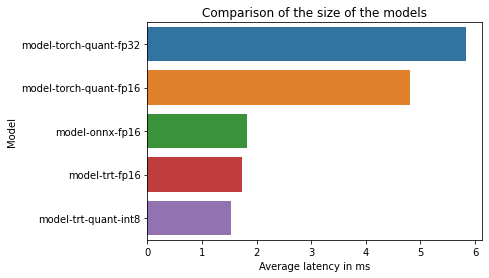

In [38]:
graph = sns.barplot(x="average_latency", y="name", data=benchmark_results_df, order=benchmark_results_df.sort_values('average_latency', ascending=False)["name"], orient="h")
graph.set_title("Comparison of the size of the models")
graph.set_ylabel("Model")
graph.set_xlabel("Average latency in ms")
plt.show()

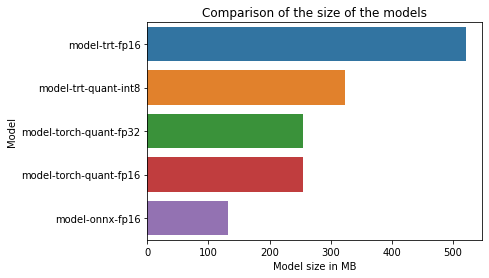

In [39]:
graph = sns.barplot(x="size", y="name", data=benchmark_results_df, order=benchmark_results_df.sort_values('size', ascending=False)["name"], orient="h")
graph.set_title("Comparison of the size of the models")
graph.set_ylabel("Model")
graph.set_xlabel("Model size in MB")
plt.show()

In [34]:
benchmark_results_df

,name,average_latency,std_latency,accuracy,size
0,model-trt-quant-int8,1.535285,0.049556,0.90711,323.336419
1,model-torch-quant-fp32,5.839292,0.25408,0.91055,255.45128
2,model-torch-quant-fp16,4.813864,0.507173,0.91055,255.45128
3,model-trt-fp16,1.733514,0.262651,0.91055,522.438625
4,model-onnx-fp16,1.816036,0.175537,0.91055,132.787996


💨 Conclusion: Techniques such as serving frameworks (e.g. ONNX, ONNX + TensorRT) and quantization can speed up transformer model inference a lot (more than 3.7x). The accuracy drop < 1%, so this is definitely a huge improvement. The TensorRT INT8 model is the fastest and ONNX fp16 model is the smallest.